In [1]:
!pip install "numpy>=1.23.5,<2.0.0" "pandas>=2.2.3" "matplotlib>=3.10.1" "tensorflow>=2.15.0" "scikit-learn>=1.3.0"

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def generate_synthetic_mobility_data(num_users=100, days=7, sampling_rate_seconds=10):
    # Define cell tower locations (grid-based for simplicity)
    grid_size = 10
    cell_towers = []
    for i in range(grid_size):
        for j in range(grid_size):
            cell_towers.append({
                'id': f'cell_{i}_{j}',
                'x': i * 1000,  # 1km spacing
                'y': j * 1000,
                'coverage_radius': 600  # meters
            })
    
    # Create mobility patterns
    data = []
    start_time = datetime.now()
    
    for user_id in range(num_users):
        # Choose a movement pattern type for this user
        pattern_type = np.random.choice(['commuter', 'random_walk', 'stationary', 'high_mobility'])
        
        # Set starting position
        if pattern_type == 'commuter':
            # Commuters typically start at home locations
            x = np.random.uniform(0, 3000)
            y = np.random.uniform(0, 3000)
        else:
            # Random starting position within the grid
            x = np.random.uniform(0, grid_size * 1000)
            y = np.random.uniform(0, grid_size * 1000)
        
        # Generate movement for each timestep
        current_time = start_time
        velocity = np.random.uniform(0.5, 2.0)  # base velocity in m/s
        
        if pattern_type == 'stationary':
            velocity = 0.1  # mostly stationary with small movements
        elif pattern_type == 'high_mobility':
            velocity = np.random.uniform(10, 30)  # high speed (e.g., vehicle)
        
        heading = np.random.uniform(0, 2*np.pi)  # initial direction
        
        for day in range(days):
            for hour in range(24):
                # Adjust behavior based on time of day
                if pattern_type == 'commuter':
                    # Morning commute (7-9 AM)
                    if 7 <= hour < 9:
                        # Head to work area
                        target_x = np.random.uniform(7000, 9000)
                        target_y = np.random.uniform(7000, 9000)
                        heading = np.arctan2(target_y - y, target_x - x)
                        velocity = np.random.uniform(5, 15)  # faster during commute
                    # Evening commute (5-7 PM)
                    elif 17 <= hour < 19:
                        # Head back home
                        target_x = np.random.uniform(0, 3000)
                        target_y = np.random.uniform(0, 3000)
                        heading = np.arctan2(target_y - y, target_x - x)
                        velocity = np.random.uniform(5, 15)
                    # At work or at home
                    else:
                        velocity = np.random.uniform(0, 0.5)  # minimal movement
                        # Random direction changes
                        if np.random.random() < 0.1:
                            heading = np.random.uniform(0, 2*np.pi)
                
                # Generate positions for this hour
                samples_per_hour = 3600 // sampling_rate_seconds
                for s in range(samples_per_hour):
                    # Add some randomness to movement
                    if np.random.random() < 0.2:
                        heading += np.random.uniform(-0.5, 0.5)
                    
                    # Update position
                    dx = velocity * sampling_rate_seconds * np.cos(heading)
                    dy = velocity * sampling_rate_seconds * np.sin(heading)
                    
                    x += dx
                    y += dy
                    
                    # Ensure within boundaries
                    x = max(0, min(x, grid_size * 1000))
                    y = max(0, min(y, grid_size * 1000))
                    
                    # Find closest cell tower
                    distances = [np.sqrt((x - tower['x'])**2 + (y - tower['y'])**2) for tower in cell_towers]
                    connected_cell_idx = np.argmin(distances)
                    connected_cell = cell_towers[connected_cell_idx]
                    signal_strength = calculate_signal_strength(distances[connected_cell_idx])
                    
                    # Find potential handover candidates
                    handover_candidates = []
                    for idx, dist in enumerate(distances):
                        if idx != connected_cell_idx and dist < connected_cell['coverage_radius'] * 1.5:
                            candidate_strength = calculate_signal_strength(dist)
                            handover_candidates.append({
                                'cell_id': cell_towers[idx]['id'],
                                'signal_strength': candidate_strength
                            })
                    
                    # Determine if handover is needed
                    handover_needed = False
                    handover_target = None
                    for candidate in handover_candidates:
                        if candidate['signal_strength'] > signal_strength + 3:  # 3dB hysteresis
                            handover_needed = True
                            handover_target = candidate['cell_id']
                            break
                    
                    # Record data point
                    timestamp = current_time + timedelta(days=day, hours=hour, seconds=s*sampling_rate_seconds)
                    data.append({
                        'timestamp': timestamp,
                        'user_id': f'user_{user_id}',
                        'x': x,
                        'y': y,
                        'velocity': velocity,
                        'heading': heading,
                        'connected_cell': connected_cell['id'],
                        'signal_strength': signal_strength,
                        'handover_needed': handover_needed,
                        'handover_target': handover_target,
                        'pattern_type': pattern_type
                    })
    
    return pd.DataFrame(data)

def calculate_signal_strength(distance):
    # Simple path loss model: -70dBm at 100m, -10dB per distance doubling
    base_signal = -70
    if distance == 0:
        return base_signal
    
    # Log-distance path loss model
    path_loss = 20 * np.log10(distance / 100)
    return base_signal - path_loss

# Generate dataset
mobility_data = generate_synthetic_mobility_data(num_users=100, days=3)

2025-04-18 19:36:38.766771: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 19:36:38.832098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 19:36:38.885378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745004998.932987    1964 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745004998.947199    1964 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745004999.052627    1964 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
def add_network_conditions(df):
    # Add time-of-day based network congestion
    df['hour'] = df['timestamp'].dt.hour
    
    # Peak hours have more congestion
    peak_hours_morning = (7 <= df['hour']) & (df['hour'] <= 9)
    peak_hours_evening = (16 <= df['hour']) & (df['hour'] <= 19)
    
    # Base network load (30-50%)
    df['network_load'] = np.random.uniform(0.3, 0.5, size=len(df))
    
    # Increase during peak hours (60-90%)
    df.loc[peak_hours_morning | peak_hours_evening, 'network_load'] = \
        np.random.uniform(0.6, 0.9, size=len(df[peak_hours_morning | peak_hours_evening]))
    
    # Add random network quality metrics
    df['sinr'] = df['signal_strength'] - np.random.uniform(-5, 5, size=len(df)) - 10 * df['network_load']
    df['throughput_mbps'] = 10 * (1 + np.log10(1 + df['sinr'])) * (1 - df['network_load']*0.7)
    
    # Add UE capabilities
    device_categories = ['5G_basic', '5G_advanced', '5G_premium']
    df['device_type'] = np.random.choice(device_categories, size=len(df))
    
    # Add handover performance metrics
    df['handover_latency'] = np.random.uniform(10, 30, size=len(df))  # ms
    
    # Some percentage of handovers fail
    df['handover_success'] = np.random.choice([True, False], size=len(df), p=[0.95, 0.05])
    
    return df

mobility_data = add_network_conditions(mobility_data)

/home/k4/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
def prepare_sequences(df, sequence_length=20):
    # Group by user
    grouped = df.groupby('user_id')
    
    sequence_data = []
    labels = []
    
    for user_id, user_data in grouped:
        user_data = user_data.sort_values('timestamp')
        
        # Create sequences
        for i in range(len(user_data) - sequence_length):
            sequence = user_data.iloc[i:i+sequence_length]
            target = user_data.iloc[i+sequence_length]
            
            # Feature vector (normalize numeric features)
            features = sequence[['x', 'y', 'velocity', 'heading', 'signal_strength', 
                               'sinr', 'network_load', 'throughput_mbps']].values
            
            # Min-max normalize 
            min_vals = features.min(axis=0, keepdims=True)
            max_vals = features.max(axis=0, keepdims=True)
            eps = 1e-8  # Avoid division by zero
            normalized_features = (features - min_vals) / (max_vals - min_vals + eps)
            
            # Target - will the user need a handover in the next step?
            handover_label = 1 if target['handover_needed'] else 0
            
            sequence_data.append(normalized_features)
            labels.append(handover_label)
    
    return np.array(sequence_data), np.array(labels)

# Prepare data for LSTM
X, y = prepare_sequences(mobility_data)

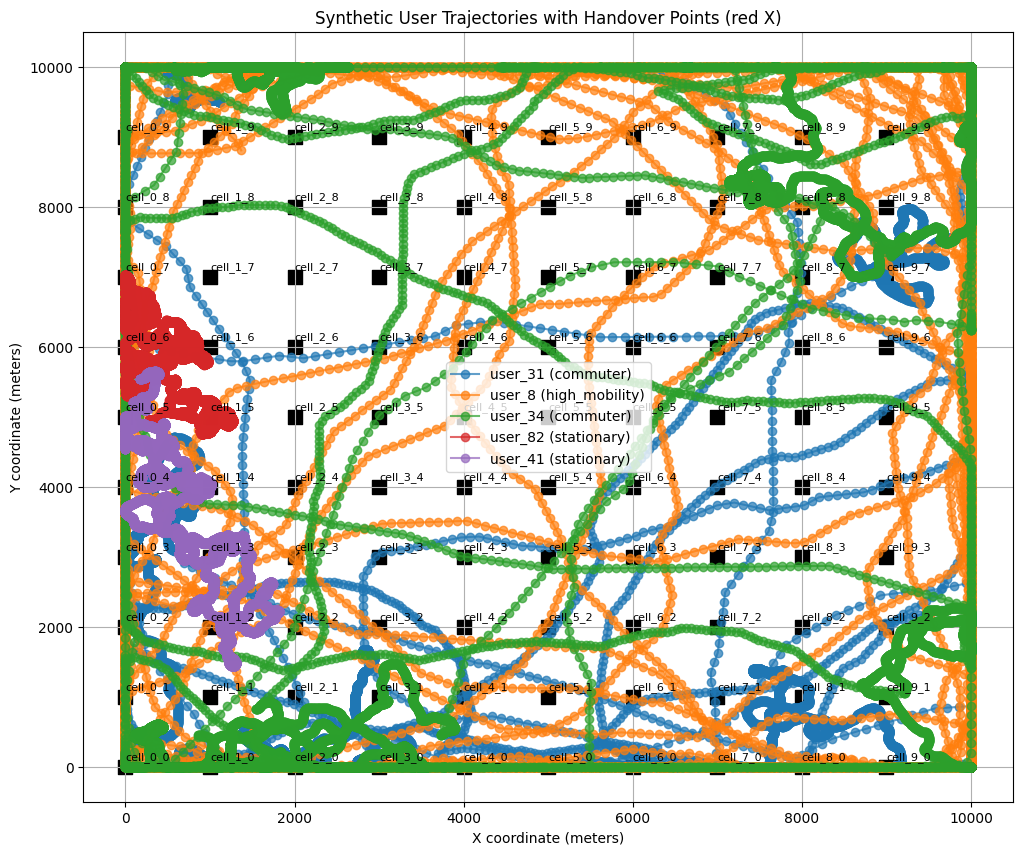

In [5]:
def visualize_trajectories(df, sample_users=5):
    plt.figure(figsize=(12, 10))
    
    user_ids = df['user_id'].unique()
    selected_users = np.random.choice(user_ids, min(sample_users, len(user_ids)), replace=False)
    
    for user_id in selected_users:
        user_data = df[df['user_id'] == user_id].sort_values('timestamp')
        plt.plot(user_data['x'], user_data['y'], 'o-', alpha=0.7, label=f"{user_id} ({user_data['pattern_type'].iloc[0]})")
        
        # Mark handovers
        handovers = user_data[user_data['handover_needed'] == True]
        plt.scatter(handovers['x'], handovers['y'], color='red', s=50, marker='x')
    
    # Plot cell towers
    grid_size = 10
    for i in range(grid_size):
        for j in range(grid_size):
            plt.scatter(i*1000, j*1000, color='black', marker='s', s=100)
            plt.text(i*1000, j*1000+100, f'cell_{i}_{j}', fontsize=8)
    
    plt.title('Synthetic User Trajectories with Handover Points (red X)')
    plt.xlabel('X coordinate (meters)')
    plt.ylabel('Y coordinate (meters)')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_trajectories(mobility_data)

In [6]:
# Check your dataset structure and basic statistics
print(f"Dataset shape: {mobility_data.shape}")
print(f"Time range: {mobility_data['timestamp'].min()} to {mobility_data['timestamp'].max()}")
print(f"Number of unique users: {mobility_data['user_id'].nunique()}")
print(f"Number of handovers: {mobility_data['handover_needed'].sum()}")

# Create a balanced dataset (optional but recommended)
handover_samples = mobility_data[mobility_data['handover_needed'] == True]
non_handover_samples = mobility_data[mobility_data['handover_needed'] == False].sample(
    n=len(handover_samples)*3,  # 1:3 ratio is often a good starting point
    random_state=42
)
balanced_data = pd.concat([handover_samples, non_handover_samples]).sort_values('timestamp')

Dataset shape: (2592000, 18)
Time range: 2025-04-18 19:36:41.410836 to 2025-04-21 19:36:31.410836
Number of unique users: 100
Number of handovers: 0


In [7]:
pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
# After generating your synthetic data
import pickle

# Save the entire mobility dataset to a pickle file
# mobility_data.to_pickle('mobility_data.pkl')
mobility_data.to_parquet('mobility_data.parquet')


# # If you created a balanced dataset, save that too
# if 'balanced_data' in locals() and not balanced_data.empty:
#     balanced_data.to_pickle('balanced_data.pkl')

# You can also save the preprocessed data (X, y, etc.)
# if 'X' in locals() and 'y' in locals():
#     with open('preprocessed_data.pkl', 'wb') as f:
#         pickle.dump({
#             'X': X,
#             'y': y,
#             'feature_names': feature_names
#         }, f)
    
#     # Save the scaler separately
#     if 'scaler' in locals():
#         with open('scaler.pkl', 'wb') as f:
#             pickle.dump(scaler, f)

print("Data saved successfully!")

Data saved successfully!


In [9]:
data_read = pd.read_parquet('mobility_data.parquet')
print(data_read)

                         timestamp  user_id            x             y  \
0       2025-04-18 19:36:41.410836   user_0  4921.168687   6146.475521   
1       2025-04-18 19:36:51.410836   user_0  4921.215629   6147.474419   
2       2025-04-18 19:37:01.410836   user_0  4921.262571   6148.473316   
3       2025-04-18 19:37:11.410836   user_0  4921.309512   6149.472214   
4       2025-04-18 19:37:21.410836   user_0  4921.356454   6150.471112   
...                            ...      ...          ...           ...   
2591995 2025-04-21 19:35:51.410836  user_99   919.817709  10000.000000   
2591996 2025-04-21 19:36:01.410836  user_99   930.365294  10000.000000   
2591997 2025-04-21 19:36:11.410836  user_99   940.912878  10000.000000   
2591998 2025-04-21 19:36:21.410836  user_99   951.460462  10000.000000   
2591999 2025-04-21 19:36:31.410836  user_99   962.008047  10000.000000   

         velocity    heading connected_cell  signal_strength  handover_needed  \
0        0.100000   1.523837  

In [10]:
import pickle

# Replace 'path_to_your_file.pkl' with the actual path to your PKL file
file_path = 'mobility_data.pkl'

# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data)

                         timestamp  user_id            x            y  \
0       2025-04-18 17:19:18.400924   user_0  3657.614676  8228.716690   
1       2025-04-18 17:19:28.400924   user_0  3658.306050  8229.439187   
2       2025-04-18 17:19:38.400924   user_0  3658.997424  8230.161684   
3       2025-04-18 17:19:48.400924   user_0  3659.688798  8230.884181   
4       2025-04-18 17:19:58.400924   user_0  3660.493091  8231.478414   
...                            ...      ...          ...          ...   
2591995 2025-04-21 17:18:28.400924  user_99  5453.479761     0.000000   
2591996 2025-04-21 17:18:38.400924  user_99  5540.066605     0.000000   
2591997 2025-04-21 17:18:48.400924  user_99  5608.487859     0.000000   
2591998 2025-04-21 17:18:58.400924  user_99  5676.909113     0.000000   
2591999 2025-04-21 17:19:08.400924  user_99  5745.330366     0.000000   

         velocity    heading connected_cell  signal_strength  handover_needed  \
0         0.10000   0.807407       cell_4_

In [11]:
# First check if we properly created our initial dataset
print(f"Original mobility_data shape: {mobility_data.shape}")
print(f"Number of handover samples: {mobility_data['handover_needed'].sum()}")

# Instead of creating a balanced dataset, let's use the original data if the balanced approach didn't work
if 'balanced_data' not in locals() or balanced_data.empty:
    print("Using original mobility data since balanced dataset is empty")
    data_for_model = mobility_data
else:
    data_for_model = balanced_data

print(f"Data for model shape: {data_for_model.shape}")

# Modified prepare_lstm_data function that's more robust to empty datasets
def prepare_lstm_data_robust(df, sequence_length=20, prediction_horizon=5):
    """
    Prepare sequential data for LSTM model with better error handling.
    """
    # Check if DataFrame is empty
    if df.empty:
        raise ValueError("Input DataFrame is empty")
        
    # Select features for model
    features = [
        'x', 'y', 'velocity', 'heading', 'signal_strength', 
        'sinr', 'network_load', 'throughput_mbps'
    ]
    
    # Check if all required columns exist
    missing_cols = [col for col in features if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Add time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.dayofweek / 7)
    
    features += ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']
    
    # One-hot encode categorical features
    if 'pattern_type' in df.columns:
        pattern_dummies = pd.get_dummies(df['pattern_type'], prefix='pattern')
        df = pd.concat([df, pattern_dummies], axis=1)
        features += list(pattern_dummies.columns)
    
    if 'device_type' in df.columns:
        device_dummies = pd.get_dummies(df['device_type'], prefix='device')
        df = pd.concat([df, device_dummies], axis=1)
        features += list(device_dummies.columns)
    
    # Create sequences
    X = []
    y = []
    
    # Group by user to maintain trajectory integrity
    for user_id, user_df in df.groupby('user_id'):
        user_df = user_df.sort_values('timestamp')
        
        # Skip users with insufficient data
        if len(user_df) <= sequence_length + prediction_horizon:
            continue
        
        for i in range(len(user_df) - sequence_length - prediction_horizon):
            # Input sequence
            seq = user_df.iloc[i:i+sequence_length][features].values
            
            # Target: will handover be needed within prediction horizon?
            target_window = user_df.iloc[i+sequence_length:i+sequence_length+prediction_horizon]
            handover_needed = target_window['handover_needed'].any()
            
            X.append(seq)
            y.append(1 if handover_needed else 0)
    
    # Check if we have any sequences
    if not X:
        raise ValueError("No valid sequences were created. Check your data and sequence length parameters.")
    
    X_array = np.array(X)
    y_array = np.array(y)
    
    # Scale numerical features after creating sequences to avoid the empty array error
    X_reshaped = X_array.reshape(-1, X_array.shape[-1])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_final = X_scaled.reshape(X_array.shape)
    
    return X_final, y_array, scaler, features

# Try again with the robust function
try:
    X, y, scaler, feature_names = prepare_lstm_data_robust(data_for_model, sequence_length=20, prediction_horizon=5)
    print(f"Successfully created sequences: X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
except Exception as e:
    print(f"Error: {e}")
    
    # If still having issues, let's try with smaller sequence length
    try:
        print("Trying with smaller sequence length...")
        X, y, scaler, feature_names = prepare_lstm_data_robust(data_for_model, sequence_length=10, prediction_horizon=3)
        print(f"Successfully created sequences: X shape: {X.shape}, y shape: {y.shape}")
        
        # Split data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
        print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
    except Exception as e:
        print(f"Error with smaller sequence: {e}")
        
        # Last resort - check if we properly created our synthetic data
        print("\nChecking synthetic data generation:")
        print("Columns in mobility_data:", mobility_data.columns.tolist())
        print("Sample of mobility_data:")
        print(mobility_data.head(2))

Original mobility_data shape: (2592000, 18)
Number of handover samples: 0
Using original mobility data since balanced dataset is empty
Data for model shape: (2592000, 18)
Successfully created sequences: X shape: (2589500, 20, 19), y shape: (2589500,)
Training set: (1812650, 20, 19), Validation set: (388425, 20, 19), Test set: (388425, 20, 19)


In [12]:
def build_mobility_prediction_model(input_shape, lstm_units=64):
    """Build LSTM model for mobility prediction"""
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(lstm_units // 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    return model

# Check if we successfully created the training data
if 'X_train' in locals() and len(X_train) > 0:
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
    model = build_mobility_prediction_model(input_shape)
    model.summary()

    # Callbacks for training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5, 
            min_lr=0.0001
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # Starting with fewer epochs for quick testing
        batch_size=32,
        callbacks=callbacks
    )
    
    print("Model training complete!")
else:
    print("Training data not available. Please fix the data preparation step first.")

2025-04-18 20:11:31.767689: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/k4/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,009 (136.75 KB)

 Trainable params: 35,009 (136.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56646/56646 ━━━━━━━━━━━━━━━━━━━━ 453s 8ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
56646/56646 ━━━━━━━━━━━━━━━━━━━━ 450s 8ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
56646/56646 ━━━━━━━━━━━━━━━━━━━━ 450s 8ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
56646/56646 ━━━━━━━━━━━━━━━━━━━━ 453s 8ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: nan - precision: 0.0000e+00

In [14]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


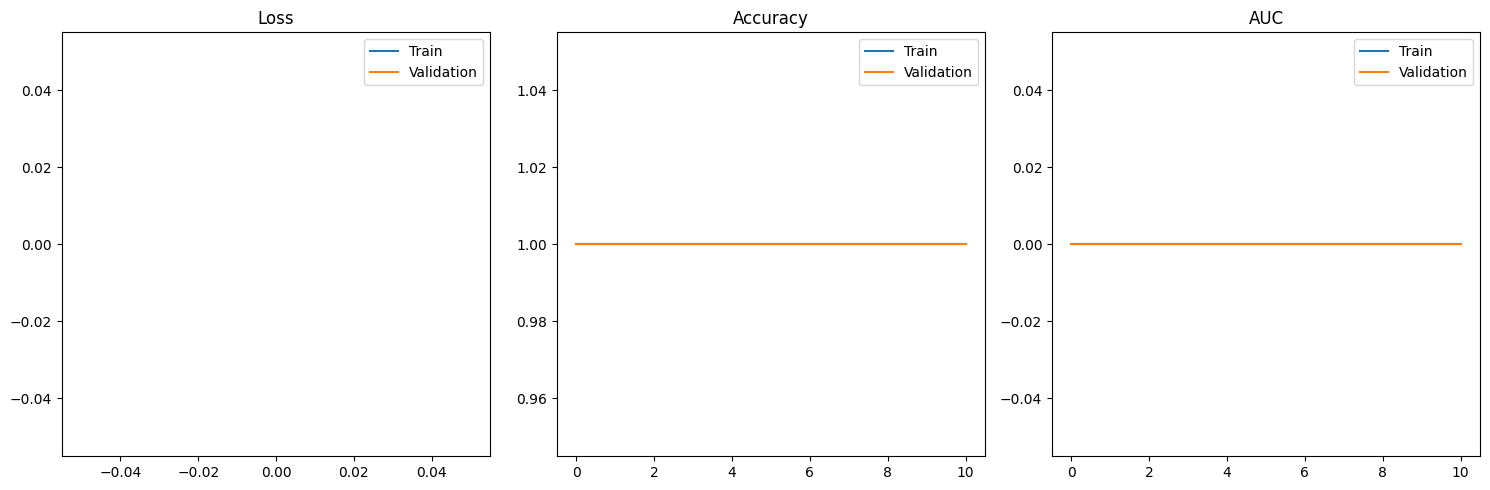

12139/12139 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00
Test accuracy: 1.0000
Test precision: 0.0000
Test recall: 0.0000
Test AUC: 0.0000
12139/12139 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


/home/k4/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


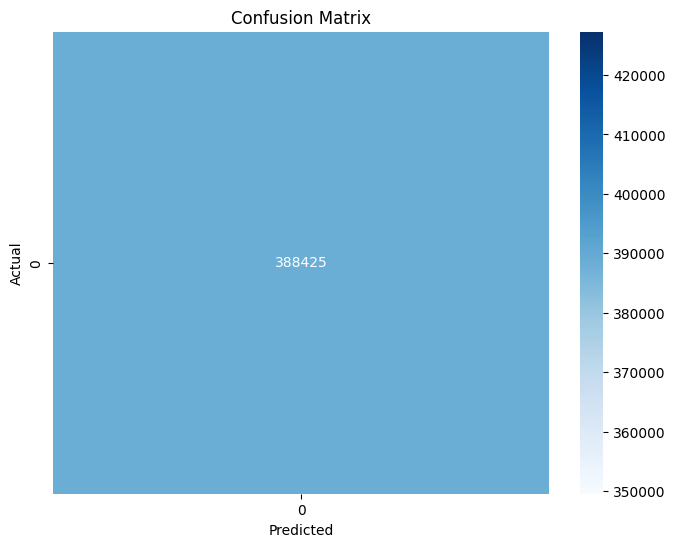

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    388425

    accuracy                           1.00    388425
   macro avg       1.00      1.00      1.00    388425
weighted avg       1.00      1.00      1.00    388425



In [15]:
# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(15, 5))
    
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train')
    plt.plot(history.history['val_auc'], label='Validation')
    plt.title('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

In [2]:
import pickle

# Replace 'path_to_your_file.pkl' with the actual path to your PKL file
file_path = 'feature_scaler.pkl'

# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data)

UnpicklingError: invalid load key, '\x06'.

In [16]:
# Save model architecture and weights
model.save('mobility_prediction_model.h5')

# Save feature names and scaler for preprocessing in production
import joblib
joblib.dump(scaler, 'feature_scaler.pkl')
with open('feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

# Create a simple prediction function for integration testing
def predict_handover(model, scaler, feature_names, user_trajectory, sequence_length=20):
    """
    Make handover prediction for a single user trajectory
    
    Args:
        model: Trained LSTM model
        scaler: Fitted StandardScaler
        feature_names: List of feature names
        user_trajectory: DataFrame with user movement data
        sequence_length: Length of input sequence
        
    Returns:
        Probability of handover needed
    """
    # Ensure we have enough data
    if len(user_trajectory) < sequence_length:
        return None
    
    # Sort by timestamp and get the latest sequence
    user_trajectory = user_trajectory.sort_values('timestamp')
    latest_sequence = user_trajectory.tail(sequence_length)
    
    # Extract and scale features
    X = latest_sequence[feature_names].values
    X_scaled = scaler.transform(X)
    
    # Reshape for model input
    X_reshaped = X_scaled.reshape(1, sequence_length, len(feature_names))
    
    # Make prediction
    handover_prob = model.predict(X_reshaped)[0][0]
    
    return handover_prob

# Test the prediction function on a sample user
sample_user_id = mobility_data['user_id'].unique()[0]
sample_trajectory = mobility_data[mobility_data['user_id'] == sample_user_id].head(30)
handover_prob = predict_handover(model, scaler, feature_names, sample_trajectory)
print(f"Handover probability for sample user: {handover_prob:.4f}")

KeyError: "['pattern_commuter', 'pattern_high_mobility', 'pattern_random_walk', 'pattern_stationary', 'device_5G_advanced', 'device_5G_basic', 'device_5G_premium'] not in index"